# Entropy SVR

Try using excess entropy to build softness-like hyperplanes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image

import sklearn

In [2]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

In [3]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

In [4]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [5]:
for job in project.find_jobs({"delta": 0, "replica": 0}, {"_CRYSTAL": {"$exists": False}}):

    delta = 0.0

    files = sorted(glob.glob(job.fn("short_runs/temp-*/struct-descr.parquet")))[:10:2]
    files2 = sorted(glob.glob(job.fn("short_runs/temp-*/sfs.parquet")))[:10:2]

In [6]:
file = files[0]
file2 = files2[0]

In [7]:
file

'/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.45/struct-descr.parquet'

In [8]:
df = pd.read_parquet(file)
df2 = pd.read_parquet(file2)
df2 = df2[df2["type"] == 0]
df["sf"] = df2["sf"]

In [9]:
len(df), len(df2)

(235935, 235935)

In [10]:
df.head()

,frame,tag,type,phop,softness,entropy,entropy-binary,entropy-binary-opt,rearrang,sf
0,0,0,0,0.000713,0.118890,-2.236004,-3.457283,-2.535503,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01931316, 0.0, 0.2..."
1,0,1,0,0.000862,-0.385413,-2.102081,-2.999533,-2.505927,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.014731606, 0.0, 0...."
2,0,2,0,0.014712,-0.009888,-2.508852,-4.182886,-2.655738,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.016687617, 0.0, 0...."
3,0,3,0,0.000485,-0.710552,-2.242270,-3.260788,-2.456938,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.02962939, 0.002191..."
4,0,4,0,0.001081,-0.273929,-3.410165,-6.389401,-3.671592,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129..."


In [11]:
tdf = df[df["frame"] == 0]

In [12]:
tdf.head()

,frame,tag,type,phop,softness,entropy,entropy-binary,entropy-binary-opt,rearrang,sf
0,0,0,0,0.000713,0.118890,-2.236004,-3.457283,-2.535503,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01931316, 0.0, 0.2..."
1,0,1,0,0.000862,-0.385413,-2.102081,-2.999533,-2.505927,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.014731606, 0.0, 0...."
2,0,2,0,0.014712,-0.009888,-2.508852,-4.182886,-2.655738,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.016687617, 0.0, 0...."
3,0,3,0,0.000485,-0.710552,-2.242270,-3.260788,-2.456938,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.02962939, 0.002191..."
4,0,4,0,0.001081,-0.273929,-3.410165,-6.389401,-3.671592,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129..."


In [37]:
from sklearn import svm, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [83]:
seed = 5
X = tdf["sf"].to_numpy()
y = tdf["entropy-binary-opt"]
max_iter = 100000
test_size = 0.2

rng = np.random.default_rng(seed)
rand_seeds = rng.integers(low=0, high=2**32-1, size=2)

shuff_y, shuff_X = shuffle(
    y, list(X), random_state=rand_seeds[0])

X_train, X_test, y_train, y_test = train_test_split(
    shuff_X, shuff_y, test_size=test_size)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', svm.LinearSVR(
        max_iter=max_iter))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(max_iter=100000))])

In [84]:
y_predict = pipe.predict(list(tdf["sf"].to_numpy()))
y_predict

array([-2.6316529 , -2.51607509, -2.59840765, ..., -2.9450742 ,
       -3.05948245, -2.52165661])

In [85]:
tdf["predict"] = y_predict

/tmp/ipykernel_25311/1538051751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf["predict"] = y_predict


In [86]:
tdf.head()

,frame,tag,type,phop,softness,entropy,entropy-binary,entropy-binary-opt,rearrang,sf,predict
0,0,0,0,0.000713,0.118890,-2.236004,-3.457283,-2.535503,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01931316, 0.0, 0.2...",-2.631653
1,0,1,0,0.000862,-0.385413,-2.102081,-2.999533,-2.505927,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.014731606, 0.0, 0....",-2.516075
2,0,2,0,0.014712,-0.009888,-2.508852,-4.182886,-2.655738,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.016687617, 0.0, 0....",-2.598408
3,0,3,0,0.000485,-0.710552,-2.242270,-3.260788,-2.456938,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.02962939, 0.002191...",-2.593517
4,0,4,0,0.001081,-0.273929,-3.410165,-6.389401,-3.671592,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129...",-2.936239


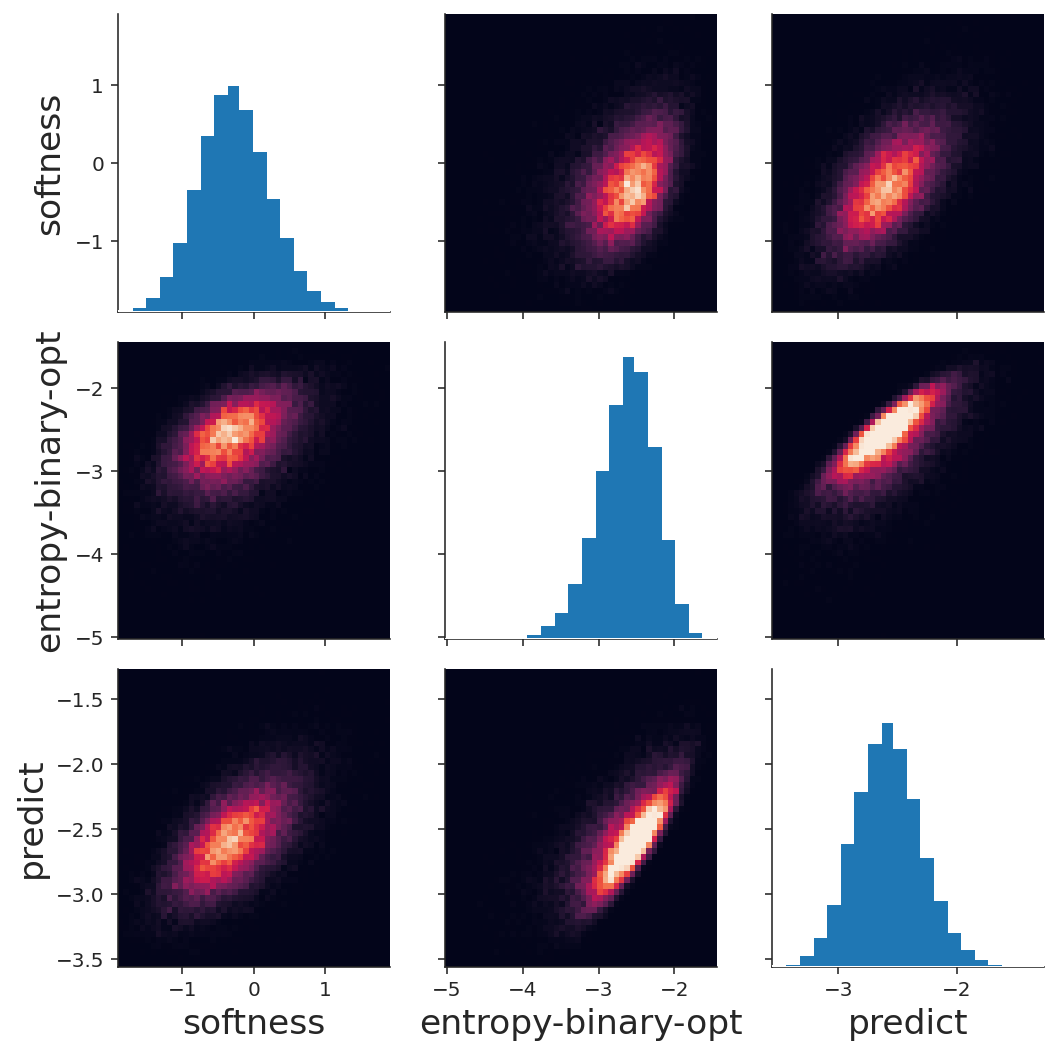

In [87]:
sns.set_style('ticks')
# sns.light_palette("white", as_cmap=True)
g = sns.PairGrid(tdf.loc[:, ["softness", "entropy-binary-opt", "predict"]])
g.map_diag(plt.hist, bins=20, histtype="stepfilled")

def pairgrid_heatmap(x, y, **kws):
    plt.hist2d(x, y, cmin=0, linewidths=0, **kws)

g.map_offdiag(pairgrid_heatmap, bins=50, norm=colors.Normalize(), cmap="rocket")

In [88]:
tdf.loc[:, ["softness", "entropy-binary-opt", "predict"]].corr()

,softness,entropy-binary-opt,predict
softness,1.000000,0.452416,0.617938
entropy-binary-opt,0.452416,1.000000,0.727138
predict,0.617938,0.727138,1.000000


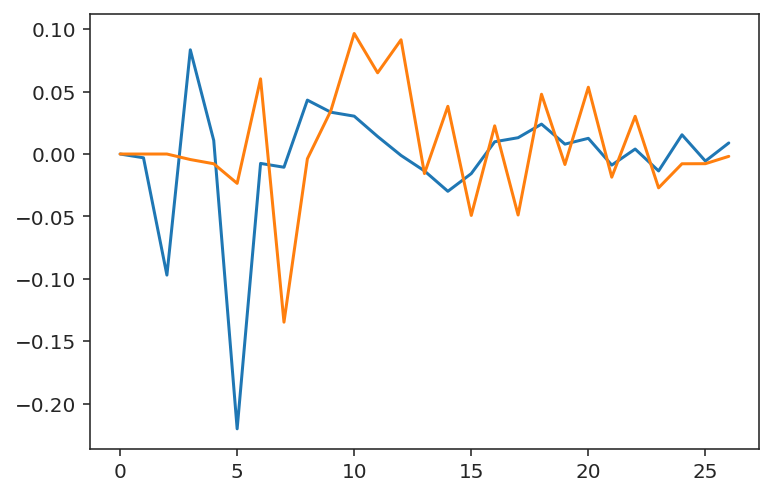

In [70]:
coefs = pipe["svr"].coef_

plt.plot(coefs[1::2])
plt.plot(coefs[::2])

In [67]:
with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
    pipeline = pickle.load(f)
pipe_softness = pipeline["pipe"]

In [69]:
coefs

array([[ 0.        ,  0.        ,  0.        , -0.01373993,  0.        ,
        -0.03697359,  0.01598795,  0.04204682,  0.26494657, -0.03484473,
        -0.07001712, -0.32341227, -0.74169057, -0.06873634, -0.23468566,
        -0.08982201, -0.6448685 , -0.03347386, -0.37280506,  0.00225854,
        -0.36274211, -0.04272859, -0.31853516, -0.02028698, -0.40241624,
        -0.18536145, -0.54674007,  0.03321285, -0.3343635 , -0.21759596,
        -0.57491918, -0.01952139, -0.37865358, -0.06802315, -0.37503706,
        -0.08811448, -0.37477898,  0.02716931, -0.26972212, -0.08455822,
        -0.21690546,  0.01084267, -0.27476314, -0.08309794, -0.23104696,
        -0.03810255, -0.11357953, -0.07299727, -0.30749201, -0.01308909,
         0.01308335, -0.0142559 , -0.19250663, -0.00823668]])

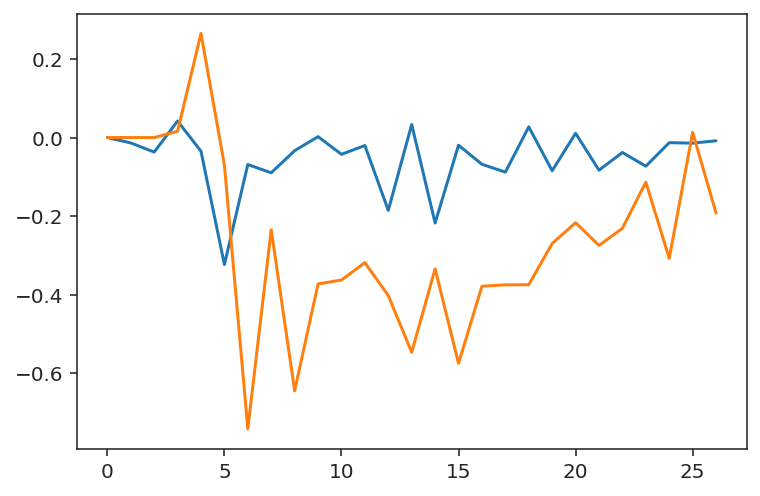

In [72]:
coefs = pipe_softness["svc"].coef_[0]

plt.plot(coefs[1::2])
plt.plot(coefs[::2])